# Palm vein recognition


Ici, vous allez trouver tous les étapes nécessaires pour développer un modèle de CNN pour la reconnaissance de veines palmaires. 

Ce projet a été développé par : Kenan GONNOT, Lorenzo MARQUES et Fayçal MERZOUK.  

**L’objectif** est de créer un modèle de veines verification : «Est-ce la bonne personne ? »

Vous pouvez retrouver ce code sur [GitHub](https://github.com/kenanGonnot/cnn_palmar_veins). 


## Table of Contents

- [1 - Imports](#1)
- [2 - Load images](#2)
    - [2.1 - Preprocess datasets](#3)
    - [2.2 - Plot image](#4)
- [3 - Split dataset - Train(70%) Test(15%) Val(15%)](#5)
- [4 - Create model CNN](#6)

## Imports

In [1]:
import gc
import glob
import os
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from random import randrange
from tqdm import tqdm, tnrange
from tqdm.notebook import tqdm_notebook

import warnings

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from keras.optimizer_v2.gradient_descent import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Lambda, Dropout, LeakyReLU, BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D
from keras.models import Sequential

from mlxtend.evaluate import accuracy

from tensorflow.keras.optimizers import Adam,RMSprop,SGD, Nadam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16

In [2]:
#tf.random.set_seed(0)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # ignore tensorflow warnings
warnings.filterwarnings("ignore")

## Load images

In [3]:
path_data = "data/data_palm_vein/NIR"

In [4]:
def load_img(path, xdim=128, ydim=128):
    label_names = []
    nmax = 6000
    X = []
    y = []
    count = 0
    #print("Loading images...")
    for dirname in tqdm_notebook(os.listdir(path), desc="Loading images..."):
        #print("dirname : ", dirname)
        label_names.append(dirname)
        data_path = os.path.join(path + "/" + dirname, '*g')
        # print("data_path: " + data_path)
        files = glob.glob(data_path)
        #print("Count = ", count)
        if count > nmax: break
        for f1 in files:
            #print("files : ", f1)
            img = cv2.imread(f1)
            #img = cv2.imread(f1, cv2.IMREAD_GRAYSCALE)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            #img = cv2.imread(f1, 0)
            #img = cv2.resize(img, (xdim, ydim))
            X.append(np.array(img))
            y.append(dirname)
            count += 1
    print(count, ' images lues')
    X = np.array(X)
    y = np.array(y)
    print("\ny.shape = ", y.shape)
    print("X.shape = ", X.shape)
    gc.collect()
    return X, y, label_names

In [5]:
def load_img3(path, xdim=512, ydim=512):
    label_names = []
    nmax = 6000
    X = []
    y = []
    count = 0
    identity = -1
    #print("Loading images...")
    for dirname in tqdm_notebook(os.listdir(path), desc="Loading images..."):
        if dirname == ".DS_Store": continue
        #print("dirname : ", dirname)
        label_names.append(dirname)
        data_path = os.path.join(path + "/" + dirname, '*g')
        # print("data_path: " + data_path)
        files = glob.glob(data_path)
        identity += 1
        #print("Count = ", count)
        if count > nmax: break
        for f1 in files:
            #print("files : ", f1)
            img = cv2.imread(f1)
            #img = cv2.imread(f1, cv2.IMREAD_GRAYSCALE)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            #img = cv2.imread(f1, 0)
            img = cv2.resize(img, (xdim, ydim))
            X.append(np.array(img))
            y.append(identity)
            count += 1
    print(count, ' images lues')
    X = np.array(X)
    y = np.array(y)
    print("\ny.shape = ", y.shape)
    print("X.shape = ", X.shape)
    gc.collect()
    return X, y, label_names

In [6]:
X, y, label_names = load_img3(path_data)

Loading images...:   0%|          | 0/501 [00:00<?, ?it/s]

6000  images lues

y.shape =  (6000,)
X.shape =  (6000, 512, 512)


### Preprocess datasets

In [7]:
X = X / 255.
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
y = tf.keras.utils.to_categorical(y)

print("\nPreprocessing data")
print("-----------------------------------------")
print("\nX shape : {}".format(X.shape))
print("-----------------------------------------")
print("y shape : {}\n".format(y.shape))


Preprocessing data
-----------------------------------------

X shape : (6000, 512, 512, 1)
-----------------------------------------
y shape : (6000, 500)



## Plot image

24


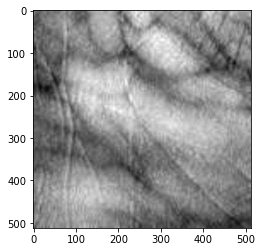

In [8]:
j = randrange(y.shape[1])
print(j)
plt.imshow(X[j], cmap='gray')
#plt.imshow(X[j])
plt.show()
#print("\ny : \n",y[j])
#print(X[j])

## Split dataset - Train(70%) Test(15%) Val(15%)

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

print("\nSplitting data ...\n")
print("-----------------------------------------------------------------------------------------")
print("\nX_train shape : {}    |   y_train shape : {}".format(X_train.shape, y_train.shape))
print("-----------------------------------------------------------------------------------------")
print("\nX_test shape  : {}    |   y_test shape  : {}".format(X_test.shape, y_test.shape))
print("-----------------------------------------------------------------------------------------")
print("\nX_val shape   : {}    |   y_val shape   : {}".format(X_val.shape, y_val.shape))


Splitting data ...

-----------------------------------------------------------------------------------------

X_train shape : (4200, 512, 512, 1)    |   y_train shape : (4200, 500)
-----------------------------------------------------------------------------------------

X_test shape  : (900, 512, 512, 1)    |   y_test shape  : (900, 500)
-----------------------------------------------------------------------------------------

X_val shape   : (900, 512, 512, 1)    |   y_val shape   : (900, 500)


## Create model CNN

### random model

In [ ]:
modelTemp = Sequential()
modelTemp.add(Conv2D(512, (3, 3), activation='relu', input_shape=(128, 128,1)))
modelTemp.add(MaxPooling2D((2, 2)))
modelTemp.add(Conv2D(256, (3, 3), activation='relu'))
modelTemp.add(MaxPooling2D((2, 2)))
modelTemp.add(Conv2D(64, (3, 3), activation='relu'))
modelTemp.add(Flatten())
modelTemp.add(Dense(1024, activation='relu'))
modelTemp.add(Dense(500, activation='sigmoid'))

modelTemp.compile(optimizer='nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

modelTemp.summary()

In [ ]:
modelTemp.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=32)
val = modelTemp.evaluate(X_test, y_test, verbose=0)

print("\nLoss  : %.2f%%" % (val[0] * 100))
print("Score : %.2f%%" % (val[1] * 100))

### Zfnet model

In [10]:
def zfnet_model(input_shape, classes):
    model = Sequential()
    model.add(Conv2D(filters=96, kernel_size=(7, 7), strides=(2, 2), padding="valid", activation="relu",
                     kernel_initializer="uniform", input_shape=input_shape))

    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # model.add(Lambda(lambda x: tf.image.per_image_standardization(x)))

    model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), padding="same",
                     activation="relu", kernel_initializer="uniform"))

    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    # model.add(Lambda(lambda x: tf.image.per_image_standardization(x)))

    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding="same",
                     kernel_initializer="uniform"))

    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding="same",
                     kernel_initializer="uniform"))
    model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding="same",
                     activation="relu", kernel_initializer="uniform"))

    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(units=4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(units=classes, activation="softmax"))

    print(model.summary())
    print("\n ================= ZFNET model ================= \n")
    # model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy',
    #               metrics=['accuracy', TopKCategoricalAccuracy(1)])
    model.compile(optimizer=Nadam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
    # model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.00001)
    # reduce_lr=0
    return model



In [11]:
Nombre_classes = len(label_names)
input_shape = (X.shape[1], X.shape[2], 1)
model = zfnet_model(input_shape, Nombre_classes)

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 253, 253, 96)      4800      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 96)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)         

In [ ]:
trained_model = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=4)

Epoch 1/4
131/132 [============================>.] - ETA: 5s - loss: 6.0858 - accuracy: 0.0043 

In [ ]:
val = model.evaluate(X_test, y_test, verbose=0)

print("\nLoss  : %.2f%%" % (val[0] * 100))
print("Score : %.2f%%" % (val[1] * 100))

#### plot score - zfnet 

In [ ]:
def plot_scores(train):
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

In [ ]:
plot_scores(trained_model)
predict_x = model.predict(X_test)
y_cnn = np.argmax(predict_x, axis=1)
plt.figure(figsize=(15, 25))
n_test = X_test.shape[0]
i = 1
for j in range(len(X_test)):
    if (y_cnn[j] != y_test[j].argmax(axis=-1)) & (i < 10):
        plt.subplot(10, 5, i)
        plt.axis('off')
        plt.imshow(X_test[j])
        plt.title('%s / %s' % (Classes[y_cnn[j]], Classes[y_test[j].argmax(axis=-1)]))
        i += 1
plt.show()

### VGG16 model

In [ ]:
from keras.applications.vgg16 import VGG16

def vgg_model_tf(input_shape=(128, 128, 1), nombre_classes=501):
    vgg16 = VGG16(weights=None, include_top=False, input_shape=input_shape)
    vgg16.trainable = False
    model = Sequential()
    model.add(vgg16)
    model.add(Flatten())
    model.add(Dense(nombre_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model

In [ ]:
model_vgg = vgg_model_tf(nombre_classes=y.shape[1])
model_vgg.summary()

In [ ]:
trained_model_vgg = model_vgg.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

In [ ]:
val = model.evaluate(X_test, y_test, verbose=0)
print("\nLoss  : %.2f%%" % (val[0] * 100))
print("Score : %.2f%%" % (val[1] * 100))

### Resnet 152 layers

In [ ]:
from keras.applications.resnet_v2 import ResNet152V2

def resnet_model_tf(input_shape=(128, 128, 1), nombre_classes=11):
    resnet = ResNet152V2(weights=None, include_top=False, input_shape=input_shape)
    resnet.trainable = False
    model = Sequential()
    model.add(resnet)
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(nombre_classes, activation='softmax'))
    
    print(model.summary())
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model

In [ ]:
model_resnet = resnet_model_tf(nombre_classes=y.shape[1])

model_resnet.load_weights('saved_model/resnet150_388_51.h5')

In [ ]:
trained_model_resnet = model_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

In [ ]:

val = model_resnet.evaluate(X_test, y_test, verbose=0)

print("\nLoss  : %.2f%%" % (val[0] * 100))
print("Score : %.2f%%" % (val[1] * 100))

## Saving models

In [ ]:
!mkdir -p saved_model
model_resnet50.save('saved_model/resnet150_388_51.h5')

### Resnet 50 layers

In [ ]:
from keras.applications.resnet import ResNet50

def resnet50_model_tf(input_shape=(128, 128, 1), nombre_classes=500):
    resnet = ResNet50(weights=None, include_top=False, input_shape=input_shape)
    resnet.trainable = False
    model = Sequential()
    model.add(resnet)
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(nombre_classes, activation='softmax'))
    
    print(model.summary())
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model

In [ ]:
model_resnet50 = resnet50_model_tf()

trained_model_resnet50 = model_resnet50.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)

In [ ]:
val = model_resnet50.evaluate(X_test, y_test, verbose=0)
print("\nLoss  : %.2f%%" % (val[0] * 100))
print("Score : %.2f%%" % (val[1] * 100))

In [ ]:
!mkdir -p saved_model
model_resnet50.save('saved_model/resnet50_200.h5')

## test model

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D

model = Sequential()
model.add(Flatten(input_shape=(128, 128, 1)))
model.add(Dense(1024, input_dim=(16384,)))
model.add(Activation('relu'))
model.add(Dropout(0.45))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.45))
model.add(Dense(501))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='sgd',
              metrics=['accuracy'])

model.summary()

In [ ]:
model.fit(X_train, y_train, epochs=2)